In [1]:
from __future__ import print_function
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from datetime import datetime, date, time, timedelta
%matplotlib inline

In [22]:
# Read data
AAPL = pd.read_csv("../Data/AAPL_05222012_0930_1300_LOB_2.csv")

In [3]:
# Change column name
AAPL.columns = [col_name.split('.')[1] if len(col_name) > 5 else col_name for col_name in AAPL.columns]

# Dimension of the data frame
AAPL.shape

(332673, 62)

### Basic Set

In [4]:
# Price and Volume
AAPL.columns

Index([u'Index', u'Time', u'BID_PRICE1', u'BID_UPDATE_TIME1', u'BID_SIZE1',
       u'ASK_PRICE1', u'ASK_UPDATE_TIME1', u'ASK_SIZE1', u'BID_PRICE2',
       u'BID_UPDATE_TIME2', u'BID_SIZE2', u'ASK_PRICE2', u'ASK_UPDATE_TIME2',
       u'ASK_SIZE2', u'BID_PRICE3', u'BID_UPDATE_TIME3', u'BID_SIZE3',
       u'ASK_PRICE3', u'ASK_UPDATE_TIME3', u'ASK_SIZE3', u'BID_PRICE4',
       u'BID_UPDATE_TIME4', u'BID_SIZE4', u'ASK_PRICE4', u'ASK_UPDATE_TIME4',
       u'ASK_SIZE4', u'BID_PRICE5', u'BID_UPDATE_TIME5', u'BID_SIZE5',
       u'ASK_PRICE5', u'ASK_UPDATE_TIME5', u'ASK_SIZE5', u'BID_PRICE6',
       u'BID_UPDATE_TIME6', u'BID_SIZE6', u'ASK_PRICE6', u'ASK_UPDATE_TIME6',
       u'ASK_SIZE6', u'BID_PRICE7', u'BID_UPDATE_TIME7', u'BID_SIZE7',
       u'ASK_PRICE7', u'ASK_UPDATE_TIME7', u'ASK_SIZE7', u'BID_PRICE8',
       u'BID_UPDATE_TIME8', u'BID_SIZE8', u'ASK_PRICE8', u'ASK_UPDATE_TIME8',
       u'ASK_SIZE8', u'BID_PRICE9', u'BID_UPDATE_TIME9', u'BID_SIZE9',
       u'ASK_PRICE9', u'ASK_UPDATE_TIME9

### Time-insenstive Set
* bid-ask spreads    
We calculate mid-price by $$Spread_i = P^{ask}_{i} - P^{bid}_{i}$$

In [5]:
AAPL['SPREAD1'] = AAPL['ASK_PRICE1'] - AAPL['BID_PRICE1']
AAPL['SPREAD2'] = AAPL['ASK_PRICE2'] - AAPL['BID_PRICE2']
AAPL['SPREAD3'] = AAPL['ASK_PRICE3'] - AAPL['BID_PRICE3']
AAPL['SPREAD4'] = AAPL['ASK_PRICE4'] - AAPL['BID_PRICE4']
AAPL['SPREAD5'] = AAPL['ASK_PRICE5'] - AAPL['BID_PRICE5']
AAPL['SPREAD6'] = AAPL['ASK_PRICE6'] - AAPL['BID_PRICE6']
AAPL['SPREAD7'] = AAPL['ASK_PRICE7'] - AAPL['BID_PRICE7']
AAPL['SPREAD8'] = AAPL['ASK_PRICE8'] - AAPL['BID_PRICE8']
AAPL['SPREAD9'] = AAPL['ASK_PRICE9'] - AAPL['BID_PRICE9']
AAPL['SPREAD10'] = AAPL['ASK_PRICE10'] - AAPL['BID_PRICE10']

* mid-prices    
$$P^{mid}_{i} = \frac{1}{2}(P^{ask}_{i} + P^{bid}_{i})$$

In [6]:
AAPL['MID_PRICE1'] = (AAPL['BID_PRICE1'] + AAPL['ASK_PRICE1'])/2
AAPL['MID_PRICE2'] = (AAPL['BID_PRICE2'] + AAPL['ASK_PRICE2'])/2
AAPL['MID_PRICE3'] = (AAPL['BID_PRICE3'] + AAPL['ASK_PRICE3'])/2
AAPL['MID_PRICE4'] = (AAPL['BID_PRICE4'] + AAPL['ASK_PRICE4'])/2
AAPL['MID_PRICE5'] = (AAPL['BID_PRICE5'] + AAPL['ASK_PRICE5'])/2
AAPL['MID_PRICE6'] = (AAPL['BID_PRICE6'] + AAPL['ASK_PRICE6'])/2
AAPL['MID_PRICE7'] = (AAPL['BID_PRICE7'] + AAPL['ASK_PRICE7'])/2
AAPL['MID_PRICE8'] = (AAPL['BID_PRICE8'] + AAPL['ASK_PRICE8'])/2
AAPL['MID_PRICE9'] = (AAPL['BID_PRICE9'] + AAPL['ASK_PRICE9'])/2
AAPL['MID_PRICE10'] = (AAPL['BID_PRICE10'] + AAPL['ASK_PRICE10'])/2

* price differences
$$\text{Range(ask)}=P^{ask}_{n} - P^{ask}_{1}$$
$$\text{Range(bid)}=P^{bid}_{1} - P^{bid}_{n}$$

In [7]:
# Range
AAPL['ASK_RANGE'] = AAPL.ASK_PRICE10 - AAPL.ASK_PRICE1
AAPL['BID_RANGE'] = AAPL.BID_PRICE1 - AAPL.BID_PRICE10

# Absolute difference for ask
AAPL['ASK21'] = np.absolute(AAPL.ASK_PRICE2 - AAPL.ASK_PRICE1)
AAPL['ASK32'] = np.absolute(AAPL.ASK_PRICE3 - AAPL.ASK_PRICE2)
AAPL['ASK43'] = np.absolute(AAPL.ASK_PRICE4 - AAPL.ASK_PRICE3)
AAPL['ASK54'] = np.absolute(AAPL.ASK_PRICE5 - AAPL.ASK_PRICE4)
AAPL['ASK65'] = np.absolute(AAPL.ASK_PRICE6 - AAPL.ASK_PRICE5)
AAPL['ASK76'] = np.absolute(AAPL.ASK_PRICE7 - AAPL.ASK_PRICE6)
AAPL['ASK87'] = np.absolute(AAPL.ASK_PRICE8 - AAPL.ASK_PRICE7)
AAPL['ASK98'] = np.absolute(AAPL.ASK_PRICE9 - AAPL.ASK_PRICE8)
AAPL['ASK109'] = np.absolute(AAPL.ASK_PRICE10 - AAPL.ASK_PRICE9)

# Absolute difference for bid
AAPL['BID21'] = np.absolute(AAPL.BID_PRICE2 - AAPL.BID_PRICE1)
AAPL['BID32'] = np.absolute(AAPL.BID_PRICE3 - AAPL.BID_PRICE2)
AAPL['BID43'] = np.absolute(AAPL.BID_PRICE4 - AAPL.BID_PRICE3)
AAPL['BID54'] = np.absolute(AAPL.BID_PRICE5 - AAPL.BID_PRICE4)
AAPL['BID65'] = np.absolute(AAPL.BID_PRICE6 - AAPL.BID_PRICE5)
AAPL['BID76'] = np.absolute(AAPL.BID_PRICE7 - AAPL.BID_PRICE6)
AAPL['BID87'] = np.absolute(AAPL.BID_PRICE8 - AAPL.BID_PRICE7)
AAPL['BID98'] = np.absolute(AAPL.BID_PRICE9 - AAPL.BID_PRICE8)
AAPL['BID109'] = np.absolute(AAPL.BID_PRICE10 - AAPL.BID_PRICE9)

* mean prices

In [8]:
# mean bid price
AAPL['MEAN_BID_PRICE'] = 0.1*(AAPL['BID_PRICE1'] + AAPL['BID_PRICE2'] + AAPL['BID_PRICE3'] +
                              AAPL['BID_PRICE4'] + AAPL['BID_PRICE5'] + AAPL['BID_PRICE6'] +
                              AAPL['BID_PRICE7'] + AAPL['BID_PRICE8'] + AAPL['BID_PRICE9'] + AAPL['BID_PRICE10'])

# mean ask price
AAPL['MEAN_ASK_PRICE'] = 0.1*(AAPL['ASK_PRICE1'] + AAPL['ASK_PRICE2'] + AAPL['ASK_PRICE3'] +
                              AAPL['ASK_PRICE4'] + AAPL['ASK_PRICE5'] + AAPL['ASK_PRICE6'] +
                              AAPL['ASK_PRICE7'] + AAPL['ASK_PRICE8'] + AAPL['ASK_PRICE9'] + AAPL['ASK_PRICE10'])

* mean volumes

In [9]:
# mean bid volume
AAPL['MEAN_BID_SIZE'] = 0.1*(AAPL['BID_SIZE1'] + AAPL['BID_SIZE2'] + AAPL['BID_SIZE3'] +
                             AAPL['BID_SIZE4'] + AAPL['BID_SIZE5'] + AAPL['BID_SIZE6'] +
                             AAPL['BID_SIZE7'] + AAPL['BID_SIZE8'] + AAPL['BID_SIZE9'] + AAPL['BID_SIZE10'])

# mean ask volume
AAPL['MEAN_ASK_SIZE'] = 0.1*(AAPL['ASK_SIZE1'] + AAPL['ASK_SIZE2'] + AAPL['ASK_SIZE3'] + 
                             AAPL['ASK_SIZE4'] + AAPL['ASK_SIZE5'] + AAPL['ASK_SIZE6'] +
                             AAPL['ASK_SIZE7'] + AAPL['ASK_SIZE8'] + AAPL['ASK_SIZE9'] + AAPL['ASK_SIZE10'])

* accumulated differences

In [10]:
# Price
AAPL['PRICE_ASK_BID'] = (AAPL['SPREAD1'] + AAPL['SPREAD2'] + AAPL['SPREAD3'] + 
                         AAPL['SPREAD4'] + AAPL['SPREAD5'] + AAPL['SPREAD6'] +
                         AAPL['SPREAD7'] + AAPL['SPREAD8'] + AAPL['SPREAD9'] + AAPL['SPREAD10'])

# Volume
AAPL['SIZE_ASK_BID'] = sum((AAPL.ASK_SIZE1 - AAPL.BID_SIZE1, AAPL.ASK_SIZE2 - AAPL.BID_SIZE2,
                            AAPL.ASK_SIZE3 - AAPL.BID_SIZE3, AAPL.ASK_SIZE4 - AAPL.BID_SIZE4,
                            AAPL.ASK_SIZE5 - AAPL.BID_SIZE5, AAPL.ASK_SIZE6 - AAPL.BID_SIZE6,
                            AAPL.ASK_SIZE7 - AAPL.BID_SIZE7, AAPL.ASK_SIZE8 - AAPL.BID_SIZE8,
                            AAPL.ASK_SIZE9 - AAPL.BID_SIZE9, AAPL.ASK_SIZE10 - AAPL.BID_SIZE10))

### Time-sensitive Set

In [11]:
# Create time variable
time = np.array([datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in AAPL['Time']])

In [19]:
def time_derivative(time, price, delta_t=1):
    derivative = np.zeros(len(price))
    
    # Find the index
    j = 0
    for i in np.arange(len(time)):
        j = i
        t_standard = time[i] - timedelta(seconds=delta_t)
        while t_standard < time[j] or time[j] == time[j - 1]:
            if j == 0: break
            j = j - 1
            
        # Once the while loop end the j will be the index of first most recent 1 second
        # We can use the index to calculate derivative
        derivative[i] = (price[i] - price[j])/(i - j + 1)
    
    return(derivative)

* Price Derivative

In [20]:
# Bid price derivative
AAPL['BID_PDERIV1'] = time_derivative(time, AAPL['BID_PRICE1'])
AAPL['BID_PDERIV2'] = time_derivative(time, AAPL['BID_PRICE2'])
AAPL['BID_PDERIV3'] = time_derivative(time, AAPL['BID_PRICE3'])
AAPL['BID_PDERIV4'] = time_derivative(time, AAPL['BID_PRICE4'])
AAPL['BID_PDERIV5'] = time_derivative(time, AAPL['BID_PRICE5'])
AAPL['BID_PDERIV6'] = time_derivative(time, AAPL['BID_PRICE6'])
AAPL['BID_PDERIV7'] = time_derivative(time, AAPL['BID_PRICE7'])
AAPL['BID_PDERIV8'] = time_derivative(time, AAPL['BID_PRICE8'])
AAPL['BID_PDERIV9'] = time_derivative(time, AAPL['BID_PRICE9'])
AAPL['BID_PDERIV10'] = time_derivative(time, AAPL['BID_PRICE10'])

# Ask price derivative
AAPL['ASK_PDERIV1'] = time_derivative(time, AAPL['ASK_PRICE1'])
AAPL['ASK_PDERIV2'] = time_derivative(time, AAPL['ASK_PRICE2'])
AAPL['ASK_PDERIV3'] = time_derivative(time, AAPL['ASK_PRICE3'])
AAPL['ASK_PDERIV4'] = time_derivative(time, AAPL['ASK_PRICE4'])
AAPL['ASK_PDERIV5'] = time_derivative(time, AAPL['ASK_PRICE5'])
AAPL['ASK_PDERIV6'] = time_derivative(time, AAPL['ASK_PRICE6'])
AAPL['ASK_PDERIV7'] = time_derivative(time, AAPL['ASK_PRICE7'])
AAPL['ASK_PDERIV8'] = time_derivative(time, AAPL['ASK_PRICE8'])
AAPL['ASK_PDERIV9'] = time_derivative(time, AAPL['ASK_PRICE9'])
AAPL['ASK_PDERIV10'] = time_derivative(time, AAPL['ASK_PRICE10'])

* Volume Derivative

In [21]:
# Bid volume derivative
AAPL['BID_SDERIV1'] = time_derivative(time, AAPL['BID_SIZE1'])
AAPL['BID_SDERIV2'] = time_derivative(time, AAPL['BID_SIZE2'])
AAPL['BID_SDERIV3'] = time_derivative(time, AAPL['BID_SIZE3'])
AAPL['BID_SDERIV4'] = time_derivative(time, AAPL['BID_SIZE4'])
AAPL['BID_SDERIV5'] = time_derivative(time, AAPL['BID_SIZE5'])
AAPL['BID_SDERIV6'] = time_derivative(time, AAPL['BID_SIZE6'])
AAPL['BID_SDERIV7'] = time_derivative(time, AAPL['BID_SIZE7'])
AAPL['BID_SDERIV8'] = time_derivative(time, AAPL['BID_SIZE8'])
AAPL['BID_SDERIV9'] = time_derivative(time, AAPL['BID_SIZE9'])
AAPL['BID_SDERIV10'] = time_derivative(time, AAPL['BID_SIZE10'])

# Ask volume derivative
AAPL['ASK_SDERIV1'] = time_derivative(time, AAPL['ASK_SIZE1'])
AAPL['ASK_SDERIV2'] = time_derivative(time, AAPL['ASK_SIZE2'])
AAPL['ASK_SDERIV3'] = time_derivative(time, AAPL['ASK_SIZE3'])
AAPL['ASK_SDERIV4'] = time_derivative(time, AAPL['ASK_SIZE4'])
AAPL['ASK_SDERIV5'] = time_derivative(time, AAPL['ASK_SIZE5'])
AAPL['ASK_SDERIV6'] = time_derivative(time, AAPL['ASK_SIZE6'])
AAPL['ASK_SDERIV7'] = time_derivative(time, AAPL['ASK_SIZE7'])
AAPL['ASK_SDERIV8'] = time_derivative(time, AAPL['ASK_SIZE8'])
AAPL['ASK_SDERIV9'] = time_derivative(time, AAPL['ASK_SIZE9'])
AAPL['ASK_SDERIV10'] = time_derivative(time, AAPL['ASK_SIZE10'])

### Reading the data after preprocessing

In [2]:
AAPL = pd.read_csv('../Data/X.csv')

C:\Users\jason\Anaconda3\envs\ipykernel_py2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (129) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Independent variable:
* mid-price movement

In [3]:
def midprice_movement(mid, delta_t):
    mid_diff = mid.diff(periods=delta_t)[delta_t:].ravel()
    mid_diff = np.append(mid_diff, np.array(np.nan).repeat(delta_t))
    
    mid_movement = (mid_diff > 0)*1 + (mid_diff < 0)*-1
    mid_movement = mid_movement.astype('float')
    mid_movement[-delta_t:] = np.nan
    
    # Change to pandas series and transform to categorical data
    mid_movement = pd.Series(pd.Categorical(mid_movement, categories=[-1, 0, 1]))
    
    # Change label
    mid_movement.cat.categories = ['down', 'stationary', 'up']
    
    return(mid_movement)

In [4]:
# Create mid-price movement
AAPL['MID_MOVEMENT'] = midprice_movement(AAPL['MID_PRICE1'], 10)

In [5]:
AAPL['MID_MOVEMENT'].value_counts()

stationary    120488
down          109929
up            102246
dtype: int64

* bid-ask spread crossing    

For bid-ask spread crossing, we have to consider three scenarios:
1. An __upward__ price spread crossing occurs when the best bid price at $t+\Delta t$ exceeds the best ask price at time $t$ $\Rightarrow$ $P^{bid}_{t + \Delta t} > P^{ask}_{t}$ 
2. A __downward__ price spread crossing happens when the best ask price at $t+\Delta t$ is less than the best bid price at time $t$ $\Rightarrow$ $P^{ask}_{t + \Delta t} < P^{bid}_{t}$ 
3. No price spread crossing takes place if $P^{ask}_{t + \Delta t} \leq P^{bid}_{t}$ and $P^{bid}_{t + \Delta t} \geq P^{ask}_{t}$ 

In [6]:
def spread_crossing(bid, ask, delta_t):
    # shifted bid (append nan at the last)
    bid_shift = np.append(bid[delta_t:], np.array(np.nan).repeat(delta_t))
    ask_shift = np.append(ask[delta_t:], np.array(np.nan).repeat(delta_t))
    
    # Determine up or down
    spread = (bid_shift > ask)*1 + (ask_shift < bid)*-1
    spread = spread.astype('float')
    spread[-delta_t:] = np.nan
    
    # Change to pandas series and transform to categorical data
    spread = pd.Series(pd.Categorical(spread, categories=[-1, 0, 1]))

    # Change label
    spread.cat.categories = ['down', 'stationary', 'up']
    
    return(spread)

In [7]:
# Create spread crossing movement
AAPL['SPREAD_CROSSING'] = spread_crossing(AAPL['BID_PRICE1'], AAPL['ASK_PRICE1'], 1000)

In [8]:
AAPL['SPREAD_CROSSING'].value_counts()

stationary    123000
down          112585
up             96088
dtype: int64

### First (before 11:00) vs. Second (after 11:00)

In [9]:
# Create time variable
time = np.array([datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in AAPL['Time']])

# Separate time by 11:00
first_index = time < datetime(2012, 5, 22, 11, 0)

# Separate training and testing set
first = AAPL.iloc[first_index]
second = AAPL.iloc[np.logical_not(first_index)]

In [10]:
first.shape

(203349, 130)

In [11]:
second.shape

(129324, 130)

### Train, Validation and Test

In [12]:
index = np.arange(first.shape[0])
np.random.seed(0)
# Shuffle the index and separate the data into train(50%), validation(25%), and test(25%) set.
np.random.shuffle(index)

train = first.iloc[index[0:101675]]
validation = first.iloc[index[101675:152512]]
test = first.iloc[index[152512:]]

In [13]:
train.shape

(101675, 130)

In [14]:
validation.shape

(50837, 130)

In [15]:
test.shape

(50837, 130)

In [16]:
# Pull out the column name in x
r_not_x = re.compile('TIME|INDEX|MID_MOVEMENT|SPREAD_CROSSING')
col_in_x = [not bool(r_not_x.search(col.upper())) for col in AAPL.columns]

In [17]:
# Separate X, y1(midprice), y2(spreadcrossing)
X_train = train.iloc[:, col_in_x]
y1_train = train['MID_MOVEMENT']
y2_train = train['SPREAD_CROSSING']

X_validation = validation.iloc[:, col_in_x]
y1_validation = validation['MID_MOVEMENT']
y2_validation = validation['SPREAD_CROSSING']

X_test = test.iloc[:, col_in_x]
y1_test = test['MID_MOVEMENT']
y2_test = test['SPREAD_CROSSING']

### Mid-price Movement

### SVM

In [19]:
#
C_range = 10.0**np.arange(2, 5, 1)
gamma_range = 10.0**np.arange(-7, -2, 1)

# Validation
V = []
for C in C_range:
    for gamma in gamma_range:
        print('Start to fit the model with C =', str(C), 'and gamma =', str(gamma))
        clf = svm.SVC(C=C, gamma=gamma)
        clf.fit(X_train.iloc[0:10000], y1_train[0:10000])
        prediction = clf.predict(X_validation)
        accuracy = np.mean(prediction == y1_validation)
        print(accuracy)
        V.append([C, gamma, accuracy])

Start to fit the model with C = 100.0 and gamma = 1e-07
0.459763558038
Start to fit the model with C = 100.0 and gamma = 1e-06
0.478076991168
Start to fit the model with C = 100.0 and gamma = 1e-05
0.45459016071
Start to fit the model with C = 100.0 and gamma = 0.0001
0.393374904105
Start to fit the model with C = 100.0 and gamma = 0.001
0.358557743376
Start to fit the model with C = 1000.0 and gamma = 1e-07
0.459193107382
Start to fit the model with C = 1000.0 and gamma = 1e-06
0.477270491965
Start to fit the model with C = 1000.0 and gamma = 1e-05
0.454649172847
Start to fit the model with C = 1000.0 and gamma = 0.0001
0.393119184846
Start to fit the model with C = 1000.0 and gamma = 0.001
0.358557743376
Start to fit the model with C = 10000.0 and gamma = 1e-07
0.456537561225
Start to fit the model with C = 10000.0 and gamma = 1e-06
0.476031237091
Start to fit the model with C = 10000.0 and gamma = 1e-05
0.454039380766
Start to fit the model with C = 10000.0 and gamma = 0.0001
0.3931

In [19]:
def model_assessment(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    
    df = pd.concat([pd.Series(precision), pd.Series(recall), pd.Series(f1)], axis=1)
    df.columns = ['precision', 'recall', 'f1']
    df.index = ['down', 'stationary', 'up']
    
    return(df)

In [23]:
clf = svm.SVC(C=100, gamma=0.000001)
clf.fit(X_train[0:10000], y1_train[0:10000])
prediction = clf.predict(X_test)
model_assessment(y1_test, prediction)

,precision,recall,f1
down,0.463724,0.523430,0.491772
stationary,0.480896,0.475187,0.478025
up,0.472635,0.413177,0.440911


### Random Forest

In [38]:
# Takes about 50 mins
# Parameters
ns_tree = [100, 200, 300, 400, 500]
ns_features = ['sqrt', 'log2']

V = []
for n in ns_tree:
    for m in ns_features:
        print('Start to fit the model with number of tree =', str(n), 'and number of features =', str(m))
        rf_clf = RandomForestClassifier(n_estimators=n, max_features=m)
        rf_clf.fit(X_train, y1_train)
        prediction = rf_clf.predict(X_validation)
        accuracy = np.mean(prediction == y1_validation)
        print(accuracy)
        V.append([n, m, accuracy])

Start to fit the model with number of tree = 100 and number of features = sqrt
0.818813069221
Start to fit the model with number of tree = 100 and number of features = log2
0.816885339418
Start to fit the model with number of tree = 200 and number of features = sqrt
0.820190019081
Start to fit the model with number of tree = 200 and number of features = log2
0.820052324095
Start to fit the model with number of tree = 300 and number of features = sqrt
0.8207014576
Start to fit the model with number of tree = 300 and number of features = log2
0.821389932529
Start to fit the model with number of tree = 400 and number of features = sqrt
0.822275114582
Start to fit the model with number of tree = 400 and number of features = log2
0.820544091902
Start to fit the model with number of tree = 500 and number of features = sqrt
0.822609516691
Start to fit the model with number of tree = 500 and number of features = log2
0.820406396916


In [111]:
rf_clf = RandomForestClassifier(n_estimators=100, max_features='sqrt')
rf_clf.fit(X_train.append(X_validation), y1_train.append(y1_validation))

prediction = rf_clf.predict(X_test)

In [112]:
model_assessment(y1_test, prediction)

,precision,recall,f1
down,0.857372,0.879330,0.868212
stationary,0.866261,0.830625,0.848069
up,0.852609,0.865064,0.858792


### Spread Crossing

### SVM

In [18]:
C_range = 10.0**np.arange(2, 5, 1)
gamma_range = 10.0**np.arange(-7, -2, 1)

# Validation
V = []
for C in C_range:
    for gamma in gamma_range:
        print('Start to fit the model with C =', str(C), 'and gamma =', str(gamma))
        clf = svm.SVC(C=C, gamma=gamma)
        clf.fit(X_train.iloc[0:10000], y2_train[0:10000])
        prediction = clf.predict(X_validation)
        accuracy = np.mean(prediction == y2_validation)
        print(accuracy)
        V.append([C, gamma, accuracy])

Start to fit the model with C = 100.0 and gamma = 1e-07
0.811770954226
Start to fit the model with C = 100.0 and gamma = 1e-06
0.837224855912
Start to fit the model with C = 100.0 and gamma = 1e-05
0.628597281508
Start to fit the model with C = 100.0 and gamma = 0.0001
0.43696520251
Start to fit the model with C = 100.0 and gamma = 0.001
0.376831835081
Start to fit the model with C = 1000.0 and gamma = 1e-07
0.800263587545
Start to fit the model with C = 1000.0 and gamma = 1e-06
0.834687334028
Start to fit the model with C = 1000.0 and gamma = 1e-05
0.627731770167
Start to fit the model with C = 1000.0 and gamma = 0.0001
0.431988512304
Start to fit the model with C = 1000.0 and gamma = 0.001
0.376831835081
Start to fit the model with C = 10000.0 and gamma = 1e-07
0.797312980703
Start to fit the model with C = 10000.0 and gamma = 1e-06
0.832326848555
Start to fit the model with C = 10000.0 and gamma = 1e-05
0.620591301611
Start to fit the model with C = 10000.0 and gamma = 0.0001
0.4319

In [21]:
clf = svm.SVC(C=100, gamma=0.000001)
clf.fit(X_train[0:10000], y2_train[0:10000])
prediction = clf.predict(X_test)
model_assessment(y2_test, prediction)

,precision,recall,f1
down,0.868566,0.878962,0.873733
stationary,0.767750,0.805274,0.786064
up,0.892356,0.826594,0.858217


### Random Forest

In [37]:
# Takes about 50 mins
# Parameters
ns_tree = [100, 200, 300, 400, 500]
ns_features = ['sqrt', 'log2']

V = []
for n in ns_tree:
    for m in ns_features:
        print('Start to fit the model with number of tree =', str(n), 'and number of features =', str(m))
        rf_clf = RandomForestClassifier(n_estimators=n, max_features=m)
        rf_clf.fit(X_train, y2_train)
        prediction = rf_clf.predict(X_validation)
        accuracy = np.mean(prediction == y2_validation)
        print(accuracy)
        V.append([n, m, accuracy])

Start to fit the model with number of tree = 100 and number of features = sqrt
0.979581800657
Start to fit the model with number of tree = 100 and number of features = log2
0.978853984303
Start to fit the model with number of tree = 200 and number of features = sqrt
0.980132580601
Start to fit the model with number of tree = 200 and number of features = log2
0.979444105671
Start to fit the model with number of tree = 300 and number of features = sqrt
0.979896532053
Start to fit the model with number of tree = 300 and number of features = log2
0.979621142082
Start to fit the model with number of tree = 400 and number of features = sqrt
0.98038829986
Start to fit the model with number of tree = 400 and number of features = log2
0.979503117808
Start to fit the model with number of tree = 500 and number of features = sqrt
0.980407970573
Start to fit the model with number of tree = 500 and number of features = log2
0.979837519917


In [82]:
rf_clf = RandomForestClassifier(n_estimators=100, max_features='sqrt')
rf_clf.fit(X_train.append(X_validation), y2_train.append(y2_validation))

prediction = rf_clf.predict(X_test)

In [84]:
np.mean(prediction == y2_test)

0.98432244231563626

$\mbox{Precision} = \frac{\mbox{True Positive}}{\mbox{True Positive + False Positive}}$

In [94]:
precision_score(y2_test, prediction, average=None) 

array([ 0.98851222,  0.97699758,  0.98826055])

$\mbox{Recall} = \frac{\mbox{True Positive}}{\mbox{True Positive + False Negative}}$

In [95]:
recall_score(y2_test, prediction, average=None)

array([ 0.98640144,  0.97936893,  0.98786294])

$\mbox{f1-score} = \frac{\mbox{2 Precision}\times\mbox{Recall}}{\mbox{Precision + Recall}}$

In [96]:
f1_score(y2_test, prediction, average=None)

array([ 0.9874557 ,  0.97818182,  0.9880617 ])

In [109]:
model_assessment(y2_test, prediction)

,precision,recall,f1
down,0.988512,0.986401,0.987456
stationary,0.976998,0.979369,0.978182
up,0.988261,0.987863,0.988062


In [98]:
pd.crosstab(y2_test, prediction, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,down,stationary,up,All
True,,,,
down,17554,241,1,17796
stationary,200,17754,174,18128
up,4,177,14732,14913
All,17758,18172,14907,50837


### Feature Selection

In [134]:
X_train.columns[[82, 83, 85, 61, 36, 60, 0, 2, 32, 28]]

Index([u'MEAN_BID_SIZE', u'MEAN_ASK_SIZE', u'SIZE_ASK_BID', u'BID_RANGE',
       u'BID_PRICE10', u'ASK_RANGE', u'BID_PRICE1', u'ASK_PRICE1',
       u'BID_PRICE9', u'BID_PRICE8'],
      dtype='object')

Feature ranking:
1. feature 82 (0.017159)
2. feature 83 (0.016408)
3. feature 85 (0.015705)
4. feature 61 (0.015100)
5. feature 36 (0.014316)
6. feature 60 (0.014146)
7. feature 0 (0.014028)
8. feature 2 (0.013582)
9. feature 32 (0.013499)
10. feature 28 (0.012634)


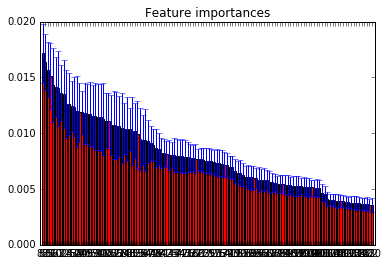

In [131]:
forest = ExtraTreesClassifier(n_estimators=100,
                              random_state=0)
forest.fit(X_train, y2_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### Strategy and Profit

### SVM

In [64]:
clf = svm.SVC(C=100, gamma=1e-6)
clf.fit(X_train[:30000], y2_train[:30000])

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1e-06, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [65]:
n_obs = second.shape[0] - 1000
pre_spread_crossing_svm = clf.predict(second.iloc[:n_obs, col_in_x])
pre_spread_crossing_svm = np.append(pre_spread_crossing_svm, np.repeat(np.nan, 1000))

pre_spread_crossing_svm = pd.Series(pre_spread_crossing_svm)

In [66]:
pd.crosstab(second['SPREAD_CROSSING'], pre_spread_crossing_svm.ravel(), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,down,stationary,up,All
True,,,,
down,0,41028,0,41028
stationary,1,50458,65,50524
up,136,36072,564,36772
All,137,127558,629,129324


### Random Forest

In [61]:
rf_clf = RandomForestClassifier(n_estimators=100, max_features='sqrt')
rf_clf.fit(X_train, y2_train)

#predit and put the label in second RANDOM FOREST
n_obs = second.shape[0] - 1000
pre_SPREAD_CROSSING_rf = rf_clf.predict(second.iloc[:n_obs, col_in_x])
pre_SPREAD_CROSSING_rf = np.append(pre_SPREAD_CROSSING_rf, np.repeat(np.nan, 1000))

pre_SPREAD_CROSSING_rf = pd.Series(pre_SPREAD_CROSSING_rf)

In [62]:
pre_SPREAD_CROSSING_rf.shape

(129324L,)

In [63]:
pd.crosstab(second['SPREAD_CROSSING'], pre_SPREAD_CROSSING_rf.ravel(), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,down,stationary,up,All
True,,,,
down,15499,1936,23593,41028
stationary,21596,3342,25586,50524
up,10919,2062,23791,36772
All,48014,7340,72970,129324


### Compute Profit

In [41]:
def compute_profit(pre, delta_t):
    
    profit = pd.Series(np.repeat(np.nan, pre.shape[0]))
    
    for i in range(pre.shape[0]):
        if pre.iloc[i] == 'up':
            profit[i] = second.iloc[i+delta_t].loc['BID_PRICE1'] - second.iloc[i].loc['ASK_PRICE1'] 
        elif pre.iloc[i] =='down':
            profit[i] = second.iloc[i].loc['BID_PRICE1'] - second.iloc[i+delta_t].loc['ASK_PRICE1'] 
        elif pre.iloc[i] == 'stationary':
            profit[i] = 0
    
    return profit

In [44]:
# SVM with 10000 samples
profit_svm = compute_profit(pre_spread_crossing_svm, 1000)
total_profit_svm = np.nansum(profit_svm)
total_profit_svm

74.039999999991437

In [67]:
profit_svm = compute_profit(pre_spread_crossing_svm, 1000)
total_profit_svm = np.nansum(profit_svm)
total_profit_svm

12.37999999999181

In [53]:
# Random Forest
profit_random_forest = compute_profit(pre_SPREAD_CROSSING_rf, 1000)
total_profit_random_forest = np.nansum(profit_random_forest)
total_profit_random_forest

-21853.630000000263

* [sklearn: Ensemble methods](http://scikit-learn.org/stable/modules/ensemble.html)
* [sklearn: Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [sklearn: SVM](http://scikit-learn.org/stable/modules/svm.html)